## Quadratic/Linear Discriminant Analysis & Naive Bayes Classification

#### *21 October 2019*
#### *DATA 1010*

In [1]:
import Pkg; Pkg.add("DataStructures")

 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]


In [2]:
using StatsBase, CSV, Plots, Distributions, DataStructures, Statistics

Today we will discuss techniques for solving classification problems when we do not have sufficient information to implement the optimal classifier. Recall that the optimal classifier for labels $Y$ given features $(X_1,\cdots,X_d)$ is the Bayesian classifier

$$
(x_1,\cdots,x_d) \mapsto \operatorname{argmax}_{i}p_i f_i(x_1,\cdots,x_d). 
$$

Implementing the optimal Bayes classifier requires knowledge of the joint density (or probability mass function) $f$ for random variables $(X_1, \cdots, X_d, Y)$. This information is typically not available in read-world applications. Therefore, we resort to making assumptions about what the distribution $f$ looks like and try to estimate it from the data we have.

## Quadratic Discriminant Analysis (QDA)

We assume that the joint density function $f_i$ for every class $i$ is a multivariate normal distribution with mean $\mathbf{\mu}_i$ and convariance matrix $\mathbf{\Sigma}_i$: 

$$ f_i \sim \mathcal{N}(\mathbf{\mu}_i,\mathbf{\Sigma}_i).$$

Note that $\sim$ means "is distributed as". We can estimate $\mathbb{\mu}$ and $\mathbb{\Sigma}$ from the data for each class $c$:

$$ \mathbf{\hat{\mu}}_{i} = \frac{1}{n_i} \sum_{\mathbf{x} \in C_i} \mathbf{x} $$

$$ \mathbf{\hat{\Sigma}}_{i} = \frac{1}{n_i - 1} \sum_{\mathbf{x} \in C_i} ( \mathbf{x} - \mathbf{\hat{\mathbf{\mu}}}_{i} ) ( \mathbf{x} - \mathbf{\hat{\mathbf{\mu}}}_{i} )'$$

where $n_i$ denotes number of observations for class $i$, and $C_i$ denotes the set of features with corresponding to class $i$. This leads to the following classifier: (p_i is estimated as ni/n, the other term is the estimated density)

$$i^* =  \operatorname{argmax}_i \Big\{ \frac{n_i}{n (2\pi)^{d/2}|\hat{\Sigma}_i|^{1/2}} e^{-\frac{1}{2}(\mathbf{x}-\hat{\mathbf{\mu}}_i)'\hat{\Sigma}_i^{-1}(\mathbf{x}-\hat{\mathbf{\mu}}_i)} \Big\}$$

Taking the logarithm and ignoring terms that don't depend on $i$, we can find the optimal class:

$$ i^* = \operatorname{argmax}_i \Big\{ \log n_i  - \frac{1}{2} \log |\hat{\Sigma}_i| - \frac{1}{2} (\mathbf{x} -\hat{\mathbf{\mu}}_i)'\hat{\Sigma}_i^{-1}(\mathbf{x}-\hat{\mathbf{\mu}}_i) \Big\} $$

---

Let's use QDA to classify Fisher's Iris dataset. This data consists of 4 features (sepal length, sepal width, petal length and petal width) for 3 species of the Iris flower. The data contains 50 observations for each species.

**Aside:** The Iris dataset (along with MNIST handwritten digits dataset, CIFAR image dataset, and Boston housing prices dataset) is widely used for teaching ML and to compare various ML algorithms. You can find more information on this dataset here: http://archive.ics.uci.edu/ml/datasets/Iris

Let's create a Flower structure and load the data:

In [3]:
using CSV, Plots

In [4]:
struct Flower
    X::Vector
    species::String
end

df = CSV.read("iris.csv", header=false, footerskip=1)
println(df[1:5,:])
println()
println("Iris dataset has size of", size(df))

5×5 DataFrames.DataFrame
│ Row │ Column1 │ Column2 │ Column3 │ Column4 │ Column5     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ String      │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────────┤
│ 1   │ 5.1     │ 3.5     │ 1.4     │ 0.2     │ Iris-setosa │
│ 2   │ 4.9     │ 3.0     │ 1.4     │ 0.2     │ Iris-setosa │
│ 3   │ 4.7     │ 3.2     │ 1.3     │ 0.2     │ Iris-setosa │
│ 4   │ 4.6     │ 3.1     │ 1.5     │ 0.2     │ Iris-setosa │
│ 5   │ 5.0     │ 3.6     │ 1.4     │ 0.2     │ Iris-setosa │

Iris dataset has size of(150, 5)


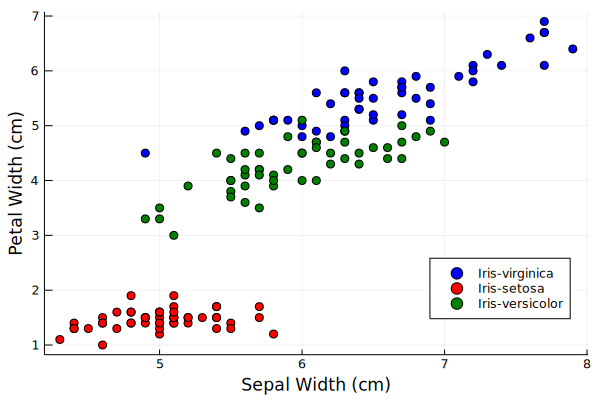

In [6]:
# Use 2D feature vector, 
# consisting of values in columns 1 (sepal length in cm) and 3 (petal length in cm), also the class
flowers = [Flower([df[i,1], df[i,3]], df[i,5]) for i = 1:size(df)[1]] # loop through all 150 data

# create dictionary mapping species to color (so s 2 c)。目的：方便我们plot
s2c = Dict("Iris-setosa" => :red, "Iris-versicolor" => :green, "Iris-virginica" => :blue)

function flower_scatter()
    P = plot(xlabel = "Sepal Width (cm)", ylabel = "Petal Width (cm)", 
             legend = :bottomright, fontfamily = "Palatino")
    # 在空图上加入scatter points
    for species in keys(s2c) # 遍历每一个花的种类，取名species
         scatter!(P, [(F.X[1], F.X[2]) for F in flowers if F.species == species], 
            color = s2c[species], label=species)
    end
    P
end

flower_scatter()

---

## Problem 1

Use QDA to train a classifier for predicting the species of flower using sepal length (in cm) and petal length (in cm). Create a heatmap showing the predicted outcome for all points in the 2-D fetaure space. What do the decision boundaries look like?

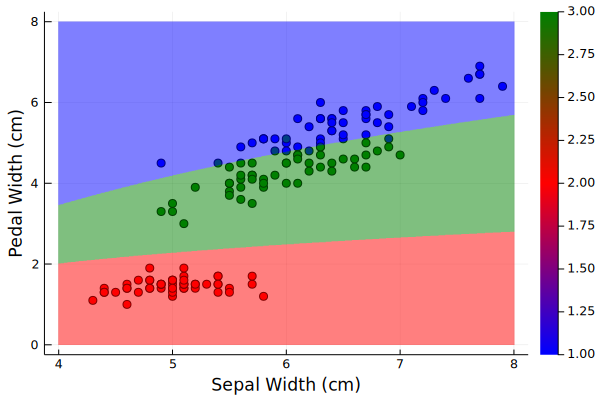

In [9]:
μ = Dict()
Σ = Dict()
Ns = Dict()

ps = proportionmap([F.species for F in flowers]) # count the propotion for each class

for species in keys(s2c)
    μ[species] = mean([F.X for F in flowers if F.species == species])
    Σ[species] = cov([F.X for F in flowers if F.species == species])
    Ns[species] = MvNormal(μ[species], Σ[species])
end

# TODO: write a function to predict the class given feature values
predict(ps, Ns, x) = argmax([ps[species] * pdf(Ns[species], x) for species in keys(s2c)])

# TODO: plot heatmap
xgrid = 4:0.01:8
ygrid = 0:0.01:8

function flower_heatmap(ps, Ns)
    heatmap!(xgrid, ygrid, (x,y) -> predict(ps, Ns, [x,y]), # note that the MvNormal takes only vector
            fillcolor = cgrad(collect(values(s2c))),
            legend = false, xlabel = "Sepal Width (cm)", ylabel = "Pedal Width (cm)",
            fontfamily = "Palatino", fillopacity = 0.5)
end

flower_scatter()
flower_heatmap(ps, Ns)

Note the decision boundary is a quadratic surface (in 2 dimension is called a conic section)

---

## Linear Discriminant Analysis (LDA) - 假设所有class的cov matrices相等，mean不一定相等

QDA assumes that samples for each class are drawn from a Gaussian distribution. Therefore, we estimate the mean and covariance for each class distribution from the data. Now, let's make another simplifying assumption. We assume that the covariance matrix for all class distributions are identical, i.e.

$$ \Sigma_1 = \cdots = \Sigma_c = \Sigma $$ 

where $c$ is the total number of classes. (Note: means might be different) 

(Reason to do LDA instead of QDA: you don't have enough data to reasonably approximate the class conditional cov matrices for each class (features too much, P features result in $P^2$ number of elements in Cov matrix))

With this assumption, we have to estimate just one convariance matrix: (这里我们estimate over all classes。但在QDA的情况，我们要estimate covariance matrtix对于每一个class) (Note that this estimator is unbiased)

$$ \hat{\Sigma} = \frac{1}{n-c} \sum_{i=1}^{c} \sum_{\mathbf{x} \in C_i} (\mathbf{x} - \hat{\mathbf{\mu}}_i) (\mathbf{x} - \hat{\mathbf{\mu}}_i)'$$

where $\hat{\Sigma}$ is pooled over all classes $i$. The optimum class is now given by:

$$ i^*  = \operatorname{argmax}_i \Big\{ \log n_i + \log p_i - \frac{1}{2} (\mathbf{x} - \hat{\mathbf{\mu}}_i)' \hat{\Sigma}^{-1} (\mathbf{x} - \hat{\mathbf{\mu}}_i) \Big\}$$

It can be shown that this assumption results in a classifier with linear decision boundaries. Therefore, this procedure is called *Linear Discriminant Analysis* 

---
Below is the difference b/w a normal Covariance estimation and LDA covariance estimation

![](images/0.PNG)

---

## Problem 2

Use LDA to train a classifier for predicting the species of flower for the Iris dataset. Compare its decision boundaries to those obtained from QDA above. 

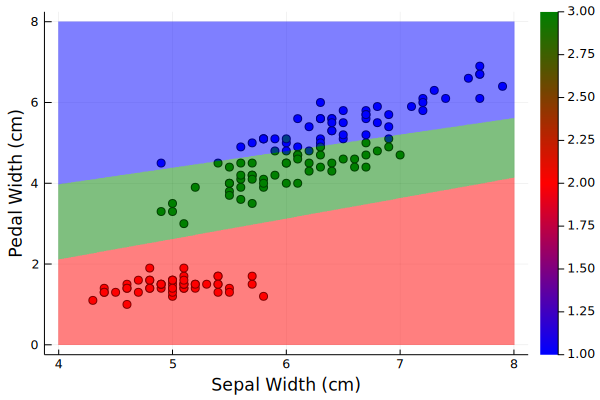

In [10]:
using Statistics, Distributions

μ = Dict()
Σ = zeros(2, 2)
Ns = Dict()

for species in keys(s2c)
    μ[species] = mean([F.X for F in flowers if F.species == species])
    Σ += sum((F.X - μ[species]) * (F.X - μ[species])'
                            for F in flowers if F.species == species)
end

Σ = Σ / (150 - 3) # 150 is number of observations, and 3 is number of classes

for species in keys(s2c)
    Ns[species] = MvNormal(μ[species], Σ)
end

flower_scatter()
flower_heatmap(ps, Ns)

## Note: we have linear boundaries separating the two classes. This is a theorem: if you have 2 multivariate Gaussian distributions with the same covariance, and you look for where they are equal, the decision boundary is always be a line.

---

## Naive Bayes Classification - 和上面不同，不假设features是Normal distr，假设features是independent （两个假设并不incompatible，如果同时假设两者，则说明diagonal entries of cov matrix are zero）

So far, we have estimated the class conditional joint probability distributions for $(X_1,\cdots,X_d)$ as multivariate Gaussians. A different simplifying assumption we can make is that the features are independent.

We can couple this assumption with a Gaussian assumption; this amounts to setting the off-diagonal entries of the covariance matrix to zero. We can also couple it with other methods of estimating the distribution of each feature. Let's look at a discrete example.

## Problem 3

Use Naive Bayes to predict the class corresponding to a given triple of integers, given the following training data for the two classes (each row corresponds to an observation; there are 40 observations for class 1, and 40 observations for class 2). 

In [21]:
# the third column is the sum of the first two (three features are not independent - X3 = X1 + X2)
# total observation is 80
# labels: first 40 is class 1, and the other 40 is class 2
X_train = 
    [5 0 5; 7 3 10; 1 3 4; 2 2 4; 4 1 5; 2 4 6; 0 0 0; 5 1 6; 3 2 5; 2 2 4; 
     0 1 1; 1 5 6; 3 2 5; 3 2 5; 2 2 4; 0 2 2; 6 2 8; 1 1 2; 3 2 5; 3 2 5; 
     7 2 9; 3 2 5; 3 1 4; 1 4 5; 2 2 4; 2 0 2; 3 1 4; 7 4 11; 3 2 5; 5 2 7; 
     6 1 7; 3 1 4; 6 6 12; 3 1 4; 0 1 1; 1 6 7; 0 3 3; 1 2 3; 4 2 6; 3 6 9; 
     1 3 4; 2 4 6; 2 2 4; 2 3 5; 0 4 4; 1 5 6; 1 5 6; 3 4 7; 2 4 6; 0 1 1; 
     3 5 8; 1 2 3; 2 5 7; 2 7 9; 1 4 5; 7 3 10; 6 4 10; 1 5 6; 1 4 5; 0 5 5; 
     2 3 5; 2 2 4; 4 2 6; 3 2 5; 2 8 10; 1 2 3; 1 2 3; 1 2 3; 2 2 4; 2 5 7; 
     0 1 1; 1 2 3; 3 9 12; 3 3 6; 5 2 7; 1 5 6; 1 3 4; 1 4 5; 0 5 5; 1 4 5];

y_train = repeat([1,2], inner = 40);

In [22]:
mutable struct NBBinaryClassifier
    classes # iterativable object containing different classes of 1 and 2
    class_proportions # 50%-50% for 2 classes
    conditional_measures # store the conditional probability mass function we get for the three features for each class
end

In [23]:
function fit!(N::NBBinaryClassifier, X, y)
    N.class_proportions = proportionmap(y_train) # also a dict map class to proportion
    # Note for the line below:
    # 1. proportionmap look up the specific class j and specific feature i in the feature matrix X
    # 2. DefaultDict return a value of 0 if the key is not found (since there may be keys we are not seeing in the training dataset)
    probability_dict(j) = [merge!(DefaultDict(0), proportionmap(X[y .== j, i]))
                                                                for i in 1:size(X,2)]
    N.conditional_measures = Dict(j => probability_dict(j) for j in N.classes)
    nothing # not returning anything
end

# naive bayes wants to multiply over total number of features - the conditional probability mass function for each observation
function predict(N::NBBinaryClassifier, x)
    # j is the class of interest 
    # i is the particular feature we are interested in
    # x[i] is the observation
    likelihood(j) = (N.class_proportions[j] * 
                    prod([N.conditional_measures[j][i][x[i]] for i in 1:length(x)])) # it's like p*f
    argmax([likelihood(j) for j in N.classes])
end

# convenient function for test matrix, iterate through each row and get the predicted class for it
function predict(N::NBBinaryClassifier, X::Matrix)
   [predict(N,row) for row in eachrow(X)]
end

predict (generic function with 3 methods)

In [24]:
# test data

N = NBBinaryClassifier(1:2, [], []) # the second and third arugments are figured out in the fit function
fit!(N, X_train, y_train)

X_test = [3 3 6; 1 1 2; 0 0 0; 2 5 7; 5 3 8; 3 2 5; 5 2 7; 1 2 3; 6 4 10; 
          5 5 10; 2 3 5; 4 4 8; 7 2 9; 4 5 9; 1 5 6; 1 2 3; 0 2 2; 3 0 3; 
          2 4 6; 3 4 7; 1 5 6; 2 1 3; 3 1 4; 3 5 8; 6 3 9; 4 1 5; 6 4 10; 
          4 5 9; 2 1 3; 4 2 6; 0 2 2; 4 3 7; 1 3 4; 2 2 4; 4 4 8; 7 2 9; 
          5 4 9; 4 2 6; 2 4 6; 1 5 6]

y_test = [fill(1, 20); fill(2, 20)]

# get the corrected classified number on the test data
sum(predict(N, X_test) .== y_test) # 17 out 40 are correct

17

Note: result is not good because we don't have enough observations and the third feature is the sum of the first two. (But with enough observations and distributions well seperated, we can still get good accuracy)

## Problem 4

In this problem, we'll discuss how to build a Naive Bayes classifier for identifying spam. You'll carry this plan out on your homework. 

An email body is a string, and it must be converted to a vector for us to apply the machine learning methods we've developed. One simple way to do that is to identify a vocabulary $W$ and associate each message with an element $X$ of $\{0,1\}^W$: an entry of 0 indicates the absence of a word in the email, while an entry of 1 indicates presence of the word.

(a) Consider the vocabulary W = {the, are, gift, click, money, baseball}. Vectorize each of the following sentences according to the scheme desribed above.

(i) Are you going to the baseball game?  
(ii) Congratulations! Click here for the gift card you won.

(b) Given a corpus of spam and legitimate emails, how should we estimate the probability that $X_1 = 1$?

(c) We can build Naive Bayes at the level of the message vectors. Describe the (highly contrived) email generation process that would lead to the measure on $\{0,1\}^W$ being assumed by Naive Bayes.

*Solution:*  
(a).  
    (i). We loop through the words and check for each one whether it's there in the email. We get `[1,1,0,0,0,1]` as a result.  
    (ii). We get `[1,0,1,1,0,0]` for this one.  
    
(b). We estimate the conditional probability of $X_1 = 1$ for legitimate message using the proportion of legitimate training message which contain the first word of $W$. Same idea for spam message.  

(c). First, we choose whether to write a spam message or a legitimate message, with probability given by the proportions of spam and legitimate massages. Then, we choose for each word in $W$ whether to include it or exclude it from our message, with each choice being independent of the others.

---

## Problem 5

Repeat problems 1 and 2 above using all 4 feature vectors: sepal length, sepal width, petal length, petal width. Note that you will not be able to do the plots, since we don't have four spatial dimensions.

---
Summary:

![](images/1.PNG)

![](images/2.PNG)

---

## Problem 6 (Challenge)

In the Naive Bayes example above, generate your own training matrices. Experiment with making the columns independent, and also with increasing the number of training observations.

---

## Problem 7 (Challenge)

When the number of features $d$ is large, it is standard practice to reduce dimensionality before using a classification algorithm. Many dimensionality reduction techniques exists, including PCA, t-SNE and multi-dimensional scaling. We will cover some of these next week. 

Obtain the handwritten digit dataset (from `MLDatasets`) and use t-SNE to reduce dimensionality to 2-dimensions. Compare classification performance and decision boundaries obtained by QDA, LDA and Naive Bayes for this dataset. Identify digits that are misclassified. 

In [11]:
using MLDatasets, TSne

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1242
ERROR: LoadError: LoadError: error compiling top-level scope: could not load library "libz"
libz.so: cannot open shared object file: No such file or directory
Stacktrace:
 [1] include at ./boot.jl:328 [inlined]
 [2] include_relative(::Module, ::String) at ./loading.jl:1094
 [3] include at ./Base.jl:31 [inlined]
 [4] include(::String) at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:2
 [5] top-level scope at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:73
 [6] include at ./boot.jl:328 [inlined]
 [7] include_relative(::Module, ::String) at ./loading.jl:1094
 [8] include(::Module, ::String) at ./Base.jl:31
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:330 [inlined]
 [11] eval(::Expr) at ./client.jl:432
 [12] top-level scope at ./none:3
in expression starting at /opt/julia/packages/GZip/LD2ly/src/zlib_h.jl:11
in expression starting at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:73
caused by [

ErrorException: Failed to precompile MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458] to /home/jovyan/.julia/compiled/v1.2/MLDatasets/9CUQK.ji.